In [1]:
# Import modules
import numpy as np
import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
import os, sys
import gc
gc.collect()

121

In [2]:
def raster2array(geotif_file):
    
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]
    
    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
        
        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)
        
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==metadata['noDataValue']]=np.nan
        array = array/metadata['scaleFactor']
        array = array[::-1] #inverse array because Python is column major
        return array, metadata
    
    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')
        
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [51]:
# Read in files as arrays
lidar_f = '/media/annie/AOP/DI_data/CHM.tif'
hs_f = '/media/annie/AOP/DI_data/NDVI.tif'

lidar_array, lidar_md = raster2array(lidar_f)
hs_array, hs_md = raster2array(hs_f)

In [52]:
# Flatten arrays for cdf function
lidar_array = lidar_array.flatten()
hs_array = hs_array.flatten()

In [53]:
lidar_samp = np.random.choice(lidar_array,500,replace=False)
hs_samp = np.random.choice(hs_array,500,replace=False)

In [54]:
# Calculate cumulative distribution
def cdf(array,out_name):
    # method 1
    test = array[~np.isnan(array)]

    H,X1 = np.histogram(test, bins = 100, normed=True)
    N = test.shape[0]
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    #method 2
    X2 = np.sort(test) #variable sorted from lowest to highest
    F2 = np.array(range(N))/float(N) #cumulative percent of variable
    
    # output
    output_array = np.vstack((X2,F2))
    np.save(out_name,output_array)
        
    return(X1,F1,X2,F2)

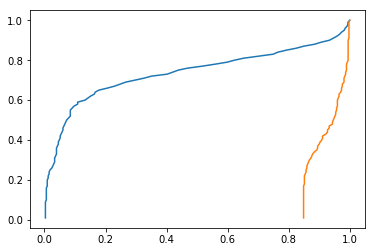

In [63]:
# Run function and plot
X1,F1,X2,F2 = cdf(hs_samp,'testing_cdf')
X1b,F1b,X2b,F2b = cdf(lidar_samp,'testing_cdf')
X1n = (X1[1:]- np.min(X1))/(np.max(X1) - np.min(X1))
X1bn = (X1b[1:]- np.min(X1b))/(np.max(X1b) - np.min(X1b))
plt.plot(F1,X1n)
plt.plot(F1b,X1bn)
#plt.plot(F2, X2)
plt.show()

In [ ]:
# Combine four outputs to single array, each row is a variable
